In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.utils.validation import check_is_fitted, check_array
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

## Creating a Saturation Effect

a = hyperparameter controling shape of saturation curve (a>0)

X = spend

saturation effect = 1-exp(a*X)

In [89]:
#with check for a greater than 0
class ExponentialSaturation(BaseEstimator,TransformerMixin):
    def __init__(self,a=.0010):
        if a > 0:
            self.a = a
        else:
            self.a = 1
    def fit(self,X,y=None):
        X = check_array(X)
        self._check_n_features(X,reset=True)
        return self
    def transform(self,X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X,reset=False)

        return 1 - np.exp(-self.a*X)

In [91]:
spend_df = data.copy()
spend_df.drop(columns=list(data.columns)[0:4],inplace=True)
spend_df["Spend_total"] = data["TV"]+data["Radio"]+data["Banners"]
spend_df

,Spend_total
Date,
2018-01-07,13528.10
2018-01-14,7568.58
2018-01-21,6282.82
2018-01-28,3562.21
2018-02-04,2187.29
...,...
2021-10-03,1691.68
2021-10-10,18677.81
2021-10-17,6475.35


In [93]:
SE = ExponentialSaturation()
spend_df["Saturated_spends"] = SE.fit_transform(spend_df[["Spend_total"]])
spend_df

,Spend_total,Saturated_spends
Date,,
2018-01-07,13528.10,0.999999
2018-01-14,7568.58,0.999484
2018-01-21,6282.82,0.998132
2018-01-28,3562.21,0.971624
2018-02-04,2187.29,0.887780
...,...,...
2021-10-03,1691.68,0.815790
2021-10-10,18677.81,1.000000
2021-10-17,6475.35,0.998459


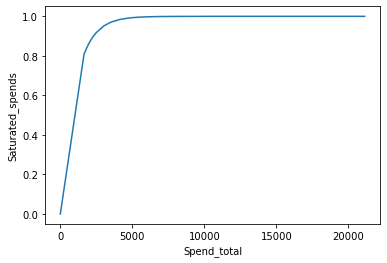

In [94]:
sns.lineplot(x=spend_df["Spend_total"],y=spend_df["Saturated_spends"]);

## Carry-Over Effect

In [95]:
from scipy.signal import convolve2d
import numpy as np
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [96]:
CE = ExponentialCarryover()
spend_df["Carried_spends"] = CE.fit_transform(spend_df[["Spend_total"]])
spend_df

,Spend_total,Saturated_spends,Carried_spends
Date,,,
2018-01-07,13528.10,0.999999,13528.100
2018-01-14,7568.58,0.999484,14332.630
2018-01-21,6282.82,0.998132,10067.110
2018-01-28,3562.21,0.971624,6703.620
2018-02-04,2187.29,0.887780,3968.395
...,...,...,...
2021-10-03,1691.68,0.815790,4070.670
2021-10-10,18677.81,1.000000,19523.650
2021-10-17,6475.35,0.998459,15814.255


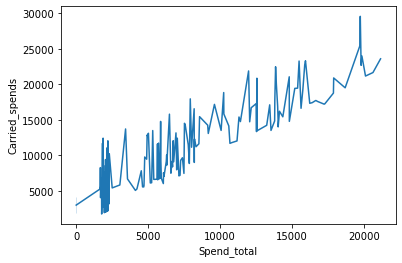

In [97]:
sns.lineplot(x=spend_df["Spend_total"],y=spend_df["Carried_spends"]);

## Pipeline

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [99]:
adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)

In [100]:
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [101]:
model.fit(X,y)

Pipeline(steps=[('adstock',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tv_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['TV']),
                                                 ('radio_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                

In [102]:
print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.6424114613881203


In [103]:
pred_v_actual_df = pd.DataFrame(data=model.predict(X),columns=["Predicted Sales"],index=X.index)
pred_v_actual_df["Actual Sales"]=y
pred_v_actual_df

,Predicted Sales,Actual Sales
Date,,
2018-01-07,8752.855907,9779.80
2018-01-14,13440.967192,13245.19
2018-01-21,9863.852345,12022.66
2018-01-28,8869.067009,8846.95
2018-02-04,9325.383330,9797.07
...,...,...
2021-10-03,9245.573170,9030.17
2021-10-10,13667.242163,15904.11
2021-10-17,13650.316861,12839.29


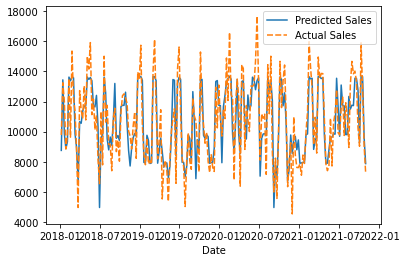

In [104]:
sns.lineplot(data=pred_v_actual_df);

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


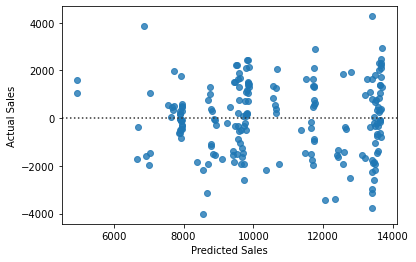

In [105]:
sns.residplot("Predicted Sales","Actual Sales",data=pred_v_actual_df);

## Grid search w/ Optuna

In [106]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution
from optuna.distributions import UniformDistribution, IntUniformDistribution

tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
    },
    n_trials=200,
    cv=TimeSeriesSplit(),
    random_state=0
)


<ipython-input-106-77a17b151994>:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuned_model = OptunaSearchCV(


In [107]:
tuned_model.fit(X,y)

[I 2022-10-12 14:52:38,297] A new study created in memory with name: no-name-7a6a84e1-5d2f-4cfe-a1fe-3cb9c99974de
[I 2022-10-12 14:52:38,376] Trial 0 finished with value: 0.13779163981195114 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: 0.13779163981195114.
[I 2022-10-12 14:52:38,426] Trial 1 finished with value: -7.206841484775084e+17 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967092952533198, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0

[I 2022-10-12 14:52:39,069] Trial 13 finished with value: 0.5294254293595316 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03484838613823089, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007515109949576203, 'adstock__radio_pipe__carryover__strength': 0.06434091848136951, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004169507569226943, 'adstock__banners_pipe__carryover__strength': 0.9992866967535542, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0035172201615055474}. Best is trial 11 with value: 0.5759188916436804.
[I 2022-10-12 14:52:39,132] Trial 14 finished with value: 0.6419576763129411 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1293727365984736, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007942340920804446, 'adstock__radio_pipe__carryover__strength': 0.3760710906749566, 'adstock__radio_pipe__carryover

[I 2022-10-12 14:52:39,894] Trial 26 finished with value: 0.5401489721742487 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9568918478478259, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007717148185238824, 'adstock__radio_pipe__carryover__strength': 0.7292940211579039, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0021624836510699265, 'adstock__banners_pipe__carryover__strength': 0.7396951876502812, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.005494992206342406}. Best is trial 17 with value: 0.6674883324700226.
[I 2022-10-12 14:52:39,955] Trial 27 finished with value: 0.5623904746185098 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20586925156508742, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006532169033180348, 'adstock__radio_pipe__carryover__strength': 0.984650917089326, 'adstock__radio_pipe__carryover__

[I 2022-10-12 14:52:40,715] Trial 39 finished with value: 0.5727253625866734 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5163282036570265, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006046007334627433, 'adstock__radio_pipe__carryover__strength': 0.22603650296327227, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.001399587681176526, 'adstock__banners_pipe__carryover__strength': 0.12037987128756994, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.003548825977555077}. Best is trial 35 with value: 0.6820541950277945.
[I 2022-10-12 14:52:40,780] Trial 40 finished with value: 0.3683981174646023 and parameters: {'adstock__tv_pipe__carryover__strength': 0.404297331870517, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0028153766017436446, 'adstock__radio_pipe__carryover__strength': 0.3152712159346233, 'adstock__radio_pipe__carryover_

[I 2022-10-12 14:52:41,540] Trial 52 finished with value: 0.7965821934224128 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6908103049726186, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0032018228837864416, 'adstock__radio_pipe__carryover__strength': 0.11980445202269874, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0004932803916013334, 'adstock__banners_pipe__carryover__strength': 0.11583703032521153, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006329060557662189}. Best is trial 52 with value: 0.7965821934224128.
[I 2022-10-12 14:52:41,602] Trial 53 finished with value: 0.7010939590430525 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7086369589674, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0035067876310144654, 'adstock__radio_pipe__carryover__strength': 0.1315381943569255, 'adstock__radio_pipe__carryover_

[I 2022-10-12 14:52:42,367] Trial 65 finished with value: 0.4766460834555898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.771828100604462, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0025121170717417674, 'adstock__radio_pipe__carryover__strength': 0.38535243968570315, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0010572371746066173, 'adstock__banners_pipe__carryover__strength': 0.26804682854249184, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.006484229716088645}. Best is trial 52 with value: 0.7965821934224128.
[I 2022-10-12 14:52:42,430] Trial 66 finished with value: 0.4652649419564616 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7343679998256298, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.005265862217149186, 'adstock__radio_pipe__carryover__strength': 0.5781198884001959, 'adstock__radio_pipe__carryover

[I 2022-10-12 14:52:43,194] Trial 78 finished with value: 0.772175862690288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4897966315514423, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.002499361200410164, 'adstock__radio_pipe__carryover__strength': 0.24073499107996363, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007156080826907162, 'adstock__banners_pipe__carryover__strength': 0.20496893985837872, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004660344441250365}. Best is trial 52 with value: 0.7965821934224128.
[I 2022-10-12 14:52:43,258] Trial 79 finished with value: 0.46985940601364035 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48070194810608924, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0010111267325531624, 'adstock__radio_pipe__carryover__strength': 0.17482403646884648, 'adstock__radio_pipe__carryov

[I 2022-10-12 14:52:44,033] Trial 91 finished with value: 0.7834494245290112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5231912540704411, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0006511036943977293, 'adstock__radio_pipe__carryover__strength': 0.303117088718245, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00847785250531151, 'adstock__banners_pipe__carryover__strength': 0.24696105477064817, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007120373124440654}. Best is trial 89 with value: 0.871679840117209.
[I 2022-10-12 14:52:44,100] Trial 92 finished with value: 0.7791876462743738 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5068116463068474, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.000778619446617988, 'adstock__radio_pipe__carryover__strength': 0.30153350498732345, 'adstock__radio_pipe__carryover__l

[I 2022-10-12 14:52:44,886] Trial 104 finished with value: 0.8525839904850064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3177381085560518, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0002966039947073175, 'adstock__radio_pipe__carryover__strength': 0.33019178442018193, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0098358306468154, 'adstock__banners_pipe__carryover__strength': 0.48025957167196187, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008692356319099159}. Best is trial 96 with value: 0.8779885664875874.
[I 2022-10-12 14:52:44,953] Trial 105 finished with value: 0.8948233019013806 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32627136227447245, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0002116588400308534, 'adstock__radio_pipe__carryover__strength': 0.3621344574411935, 'adstock__radio_pipe__carryov

[I 2022-10-12 14:52:45,740] Trial 117 finished with value: 0.7950818751071249 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34702007361039666, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007098171477629707, 'adstock__radio_pipe__carryover__strength': 0.43843365477332025, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008597825298061693, 'adstock__banners_pipe__carryover__strength': 0.5647118014288024, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009762305142088009}. Best is trial 109 with value: 0.8982114061266617.
[I 2022-10-12 14:52:45,805] Trial 118 finished with value: 0.818163736840523 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22997663853076772, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0011265964554491806, 'adstock__radio_pipe__carryover__strength': 0.4084910064513727, 'adstock__radio_pipe__carry

[I 2022-10-12 14:52:46,599] Trial 130 finished with value: 0.6756494092007062 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36145409935026385, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0014428904747223702, 'adstock__radio_pipe__carryover__strength': 0.5530805894103966, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008977594923910297, 'adstock__banners_pipe__carryover__strength': 0.4344986395836217, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00919691897191336}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-12 14:52:46,664] Trial 131 finished with value: 0.8972142428661574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29280027611262804, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00017752897316588968, 'adstock__radio_pipe__carryover__strength': 0.45592444332056586, 'adstock__radio_pipe__carr

[I 2022-10-12 14:52:47,445] Trial 143 finished with value: 0.896798660505872 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3459979663383207, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0002468834807763411, 'adstock__radio_pipe__carryover__strength': 0.49112222625248103, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009468404158119118, 'adstock__banners_pipe__carryover__strength': 0.5398828790205887, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009602478012141525}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-12 14:52:47,510] Trial 144 finished with value: 0.8477434114309517 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2619386212638026, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0006743182109969286, 'adstock__radio_pipe__carryover__strength': 0.497716033617498, 'adstock__radio_pipe__carryove

[I 2022-10-12 14:52:48,301] Trial 156 finished with value: 0.7600922262553211 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3518843392740135, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0008751069210842728, 'adstock__radio_pipe__carryover__strength': 0.49598967491832047, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0075102808282228525, 'adstock__banners_pipe__carryover__strength': 0.5146043186135948, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009699837444893816}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-12 14:52:48,367] Trial 157 finished with value: 0.8728104776465775 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30443481420758245, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0004122247889282695, 'adstock__radio_pipe__carryover__strength': 0.5414431941443715, 'adstock__radio_pipe__carr

[I 2022-10-12 14:52:49,158] Trial 169 finished with value: 0.7410663985352441 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35813561805442695, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.000958452781773477, 'adstock__radio_pipe__carryover__strength': 0.44353596100415116, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007475685686697451, 'adstock__banners_pipe__carryover__strength': 0.5575859585177178, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009038833932746685}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-12 14:52:49,225] Trial 170 finished with value: 0.6699010711072629 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4057574849625583, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00028729329833617465, 'adstock__radio_pipe__carryover__strength': 0.48724423138100137, 'adstock__radio_pipe__carr

[I 2022-10-12 14:52:50,020] Trial 182 finished with value: 0.900753181367104 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3300255569441071, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00022634137043821333, 'adstock__radio_pipe__carryover__strength': 0.4647974628934875, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00910854730266651, 'adstock__banners_pipe__carryover__strength': 0.4870141573799829, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009141354816972539}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-12 14:52:50,086] Trial 183 finished with value: 0.8755378567303944 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33442094015331264, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 8.44792505653785e-06, 'adstock__radio_pipe__carryover__strength': 0.4718453858225078, 'adstock__radio_pipe__carryove

[I 2022-10-12 14:52:50,887] Trial 195 finished with value: 0.8213966172294823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33487216057879726, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006075810638968258, 'adstock__radio_pipe__carryover__strength': 0.4188033522579154, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008800750717453017, 'adstock__banners_pipe__carryover__strength': 0.4661386742305582, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009238161567278504}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-12 14:52:50,953] Trial 196 finished with value: 0.9052111891818624 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3656789370810763, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019758925984232652, 'adstock__radio_pipe__carryover__strength': 0.4767639572317762, 'adstock__radio_pipe__carry

OptunaSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            ExponentialSaturation())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                           Pipeline(ste

In [109]:
tuned_model.best_params_

{'adstock__tv_pipe__carryover__strength': 0.3725327481651027,
 'adstock__tv_pipe__carryover__length': 6,
 'adstock__tv_pipe__saturation__a': 0.0001582863231734673,
 'adstock__radio_pipe__carryover__strength': 0.4778243890027402,
 'adstock__radio_pipe__carryover__length': 0,
 'adstock__radio_pipe__saturation__a': 0.009687575686379471,
 'adstock__banners_pipe__carryover__strength': 0.5533992606401912,
 'adstock__banners_pipe__carryover__length': 0,
 'adstock__banners_pipe__saturation__a': 0.008620223901631427}

In [137]:
tuned_model.best_estimator_.named_steps['regression'].intercept_

5413.550593065648

In [135]:
best_model_coef_df = pd.DataFrame(data=tuned_model.best_estimator_.named_steps['regression'].coef_.flatten())
best_model_coef_df.index = list(X.columns)
best_model_coef_df = best_model_coef_df.rename(columns={0:"Best Model Coefficients"})

In [136]:
best_model_coef_df

,Best Model Coefficients
TV,6046.555592
Radio,2326.058942
Banners,2423.400032


# Grid search w/ RandomSearch

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [20]:
rand_tuned_model = RandomizedSearchCV(
    estimator=model,
    param_distributions={
        'ad_effect_pipe__tv_pipe__carryover__strength': FloatDistribution(0, 1),
        'ad_effect_pipe__tv_pipe__carryover__length': IntDistribution(0, 6),
        'ad_effect_pipe__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
        'ad_effect_pipe__radio_pipe__carryover__strength': FloatDistribution(0, 1),
        'ad_effect_pipe__radio_pipe__carryover__length': IntDistribution(0, 6),
        'ad_effect_pipe__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
        'ad_effect_pipe__banners_pipe__carryover__strength': FloatDistribution(0, 1),
        'ad_effect_pipe__banners_pipe__carryover__length': IntDistribution(0, 6),
        'ad_effect_pipe__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
    },
    n_iter=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)


In [21]:
cross_val_score(tuned_model,X,y)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py:88: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


RuntimeError: Cannot clone object OptunaSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
               estimator=Pipeline(steps=[('ad_effect',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            SaturationEffect())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',...
                                    'ad_effect_pipe__radio_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                                    'ad_effect_pipe__tv_pipe__carryover__length': IntDistribution(high=6, log=False, low=0, step=1),
                                    'ad_effect_pipe__tv_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'ad_effect_pipe__tv_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None)},
               random_state=0), as the constructor either does not set or modifies parameter param_distributions